# Topic Modelling

This Notebook preforms data exploration on the SQL database containing twitter data. The goal is to use topic modelling methods to look for tweet topics that may contaminate the SQL database.


## Problem:
When we query the database for car brands, such as the company 'FORD', the database contains topics related to people like 'Doug Ford', 'Harrison Ford', ect. Because these are topics not related to car brands, we want to find these contaminating topics and remove them from the database. It is not always clear ahead of time what the contaminating topics are, so for that reason we must use topic modelling to give us this insight.

## Solution:
1. Select the car brand of interest, load data into Pandas
2. Process the tweets of the resulting data frame, remove puncuation ect.
3. Convert text corpus into feature matrix using TFIDF vectorizer $A$
4. Perform Non-negative factorization of document matrix with topic number $k$  
    * Optimize the number of topics by computing a topic cohesion metrics, and maximizing this value
    assuming $k > 1$
    * The topic cohesion metric is computed using a prebuilt word embedding model that can compute term similarities
5. Once optimal number of topics are selected, the mtop descriptive terms are analysed to understand what the topic is, and whether it should be removed from the data set.
6. A choice is made and a threshold is chosen that removes tweets that are above the threshold for belonging to a specified topic.  


### References
Derek Greene has an excellent tutorial for topic modelling.  
https://github.com/derekgreene/topic-model-tutorial

In [6]:
import warnings
warnings.filterwarnings('ignore')

import os.path
import sqlite3
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from process_text import clean_up_text
from process_text import preprocess
from process_text import string_cohesion
from sklearn.feature_extraction.text import TfidfVectorizer


#conn = sqlite3.connect('location_based_database.db')
conn = sqlite3.connect('keyword_based_database.db')
#c = conn.cursor()
#c.execute('''SELECT * FROM tweet;''')

# Read into a Pandas Data Frame
q='''
SELECT * FROM tweet
WHERE LOWER(tweet_text) LIKE '%ford%'
AND LOWER(tweet_text) NOT LIKE '%harrison%'  
AND LOWER(tweet_text) NOT LIKE '%doug%'
AND LOWER(tweet_text) NOT LIKE '%government%'
LIMIT 10000;
'''
q1='''
SELECT * FROM tweet
WHERE LOWER(tweet_text) LIKE '%bmw%'  
AND LOWER(tweet_text) NOT LIKE '%police%'
LIMIT 10000;
'''

q2='''
SELECT * FROM tweet
WHERE LOWER(tweet_text) LIKE '%toyota%'  
LIMIT 10000;
'''

q3='''
SELECT * FROM tweet
WHERE LOWER(tweet_text) LIKE '%porsche%'
AND LOWER(tweet_text) NOT LIKE '%davido%'
AND LOWER(tweet_text) NOT LIKE '%nuamah%'
AND LOWER(tweet_text) NOT LIKE '%actor%'
AND LOWER(tweet_text) NOT LIKE '%police%'
LIMIT 10000;
'''

q4='''
SELECT * FROM tweet
WHERE LOWER(tweet_text) LIKE '%mercedes%'
LIMIT 10000;
'''

q5='''
SELECT * FROM tweet
WHERE LOWER(tweet_text) LIKE '%tesla%'
AND LOWER(tweet_text) NOT LIKE '%elon%'
AND LOWER(tweet_text) NOT LIKE '%musk%'
AND LOWER(tweet_text) NOT LIKE '%solar roof%'
AND LOWER(tweet_text) NOT LIKE '%stock%'
AND LOWER(tweet_text) NOT LIKE '%production rate%'
AND LOWER(tweet_text) NOT LIKE '%money model%'
AND LOWER(tweet_text) NOT LIKE '%industry%'
AND LOWER(tweet_text) NOT LIKE '%net loss%'
AND LOWER(tweet_text) NOT LIKE '%loss%'
AND LOWER(tweet_text) NOT LIKE '%profit%'
AND LOWER(tweet_text) NOT LIKE '%atari%'
AND LOWER(tweet_text) NOT LIKE '%financial%'
AND LOWER(tweet_text) NOT LIKE '%earn%'
AND LOWER(tweet_text) NOT LIKE '%quarterly%'
AND LOWER(tweet_text) NOT LIKE '%record%'
AND LOWER(tweet_text) NOT LIKE '%market%'
AND LOWER(tweet_text) NOT LIKE '%outsell%'
AND LOWER(tweet_text) NOT LIKE '%produce%'
LIMIT 10000;
'''

q6='''
SELECT * FROM tweet
WHERE LOWER(tweet_text) LIKE '%tesla%'
AND LOWER(tweet_text) NOT LIKE '%solar roof%'
AND LOWER(tweet_text) NOT LIKE '%atari%'
AND created_at LIKE '%Aug 08%'
LIMIT 10000;
'''

#df = pd.read_sql_query("SELECT * FROM tweet where tweet_text like '% Ford %' LIMIT 10000;",conn)
df = pd.read_sql_query(q6,conn)

---------------------------------------------------------
Column names: 
 ['tweet_id_text', 'tweet_hashtag', 'tweet_text', 'created_at', 'geo_lat', 'geo_long', 'user_id_text'] 

The number of tweets:  3755 

---------------------------------------------------------
0    @eIonmtuk @girllovesbread @lexiheft @Tesla @el...
1    RT @_Amixem: Hi @Tesla, I would like to make a...
2    Tesla is working on a new key fob – potentiall...
3    RT @AhmAsmiYodha: Nikola Tesla (10 July 1856 –...
4    Elon Musk believes going private could minimiz...
5    #Digital disruptors: How @Airbnb @Tesla and @U...
6    Tesla Gains Nearly $4 Billion After Single Que...
7    RT @drewharwell: Taking Tesla private at $420 ...
8    @elonmusk Will you still share economic report...
9    Elon Musk Considering Taking Tesla Private In ...
Name: tweet_text, dtype: object


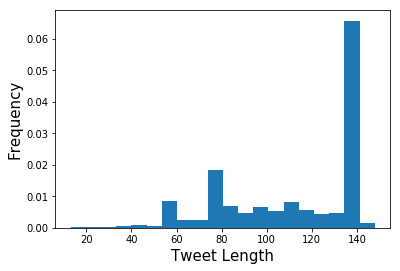

In [7]:
# Some simple Data exploration

N_raw_tweets = len(df)

print('---------------------------------------------------------')
print('Column names: \n', list(df.columns.values),"\n")
print('The number of tweets: ', N_raw_tweets,'\n')
print('---------------------------------------------------------')

# Show the First ten items in the tweet database
print(df['tweet_text'][0:10])



# A small data frame to plot the length of the tweets
df_len= df['tweet_text'].apply(len)
plt.hist(df_len,bins=20,density=True)
plt.ylabel('Frequency',size=15)
plt.xlabel('Tweet Length',size=15)
plt.savefig('tweet_length_histogram_raw.pdf',bboxes='tight')
plt.show()

Example text: 

Why Elon Musk wants to take Tesla private https://t.co/9AexObX4Pf 

Processed text: 

elon musk want take tesla private 



The number of tweets after removing duplicates:  1417 

Fraction removed:  0.623


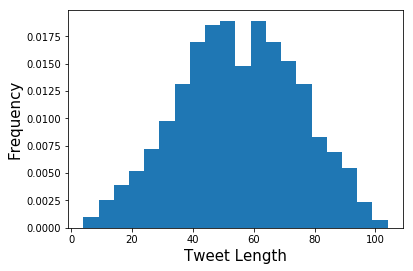

In [8]:
text = df['tweet_text'][80]

print('=============================================================')
print("Example text: \n")
print(text,'\n')
print("Processed text: \n")
print(clean_up_text(text),'\n')
print('=============================================================')

# Apply the 'Clean-up-text function to all tweets in the data frame'
df['tweet_text'] = df['tweet_text'].apply(clean_up_text)

#print('The size of the table: ', len(df),'\n')


# Remove duplicate tweets and reset the index
df.drop_duplicates(subset='tweet_text', keep='first', inplace=True)
df=df.reset_index(drop=True)

N_processed_tweets = len(df)

print('\n')
print('=============================================================')
print('The number of tweets after removing duplicates: ', N_processed_tweets ,'\n')
print('Fraction removed: ', round(1.0-(N_processed_tweets/float(N_raw_tweets)),3) )
print('=============================================================')

# A small data frame to plot the length of the tweets
df_len= df['tweet_text'].apply(len)
plt.hist(df_len,bins=20,density=True)
plt.ylabel('Frequency',size=15)
plt.xlabel('Tweet Length',size=15)
plt.savefig('tweet_length_histogram_processed.pdf',bboxes='tight')
plt.show()

In [9]:
# We create a snippet array and a raw document array to hold all of tweets

raw_documents = []
snippets = []

for k in range(0,len(df)):
    text = df['tweet_text'][k]
    raw_documents.append(text)
    snippets.append(text)

print("Read %d raw tweets documents" % len(raw_documents))

#We will load in the custom stop words
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )

# we pass processing parameters
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)

# Using the Tfidvectorizer we generate the document matrix
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

# extract the resulting vocabulary
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Read 1417 raw tweets documents
Created 1417 X 75 TF-IDF-normalized document-term matrix
Vocabulary has 75 distinct terms


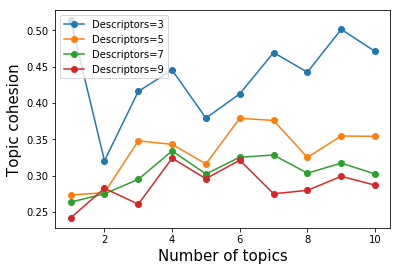

Optimal Topics:  6


In [10]:
from sklearn import decomposition
import scipy as sc


def get_descriptor( terms, H, topic_index, top ):
    '''
    This function can return the 
    
    H: 
    topic_index: integer, corresponds to the topic chosen
    top: The number of topics that will be returned
    terms: The words in the vocabulary
    '''
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    
    return top_terms


def topic_grid_search(A,N_descriptors,kmin=1,kmax=10):
    
    cohesion_array = []
    k_array = []
    
    for k in range(kmin,kmax+1):
        model = decomposition.LatentDirichletAllocation(n_components=k, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
        W = model.fit_transform( A )
        H = model.components_
        N_topic_samples = []
        
        descriptors = []
        word_dict = {}
        topics_cohesion = 0.0
        
        for topic_index in range(k):
            s=get_descriptor( terms, H, topic_index, N_descriptors )
            
            # Concatenate the array of strings into a single string
            sk=' '.join(s)
            topics_cohesion+=string_cohesion(sk)
            descriptors.append(s)
            str_descriptor = ", ".join( descriptors[topic_index] )
            word_dict['Topic # ' + '{:02d}'.format(topic_index+1)] = [word for word in descriptors[topic_index]];
    
        ca = topics_cohesion/float(k)
        cohesion_array.append(ca)
        k_array.append(k)
    
    return k_array,cohesion_array


k_array,cohesion_array0 = topic_grid_search(A,N_descriptors=3,kmin=1,kmax=10)
k_array,cohesion_array = topic_grid_search(A,N_descriptors=5,kmin=1,kmax=10)
k_array,cohesion_array2 = topic_grid_search(A,N_descriptors=7,kmin=1,kmax=10)
k_array,cohesion_array3 = topic_grid_search(A,N_descriptors=9,kmin=1,kmax=10)

# Data Frame with Topic words
plt.plot(k_array,cohesion_array0,'-o',label='Descriptors=3')
plt.plot(k_array,cohesion_array,'-o',label='Descriptors=5')
plt.plot(k_array,cohesion_array2,'-o',label='Descriptors=7')
plt.plot(k_array,cohesion_array3,'-o',label='Descriptors=9')
plt.ylabel('Topic cohesion',size=15)
plt.xlabel('Number of topics', size=15)
plt.legend()
plt.savefig('topics_vs_cohesion_Ndescriptors_.pdf',bboxes='tight')
plt.show()

# Fit the optimal number of topics 
k0 = k_array[np.argmax(cohesion_array)]
print('Optimal Topics: ', k0)

In [11]:
k = k0
model = decomposition.LatentDirichletAllocation(n_components=k, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

# apply the model and extract the two factor matrices
W = model.fit_transform( A )
H = model.components_

descriptors = []
word_dict = {}

for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 20 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    word_dict['Topic # ' + '{:02d}'.format(topic_index+1)] = [word for word in descriptors[topic_index]];

# Data Frame with Topic words
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06
0,musk,tesla,car,buyout,market,no
1,private,model,drive,tesla,think,tsla
2,elon,now,tesla,get,day,tesla
3,take,should,good,see,stock,build
4,tesla,new,electric,time,price,not
5,go,can,im,sho,tesla,saudi
6,tweet,investor,ceo,deal,could,idea
7,share,buy,like,bombshell,look,fund
8,company,move,go,sell,today,wednesday
9,consider,like,company,need,public,briefing


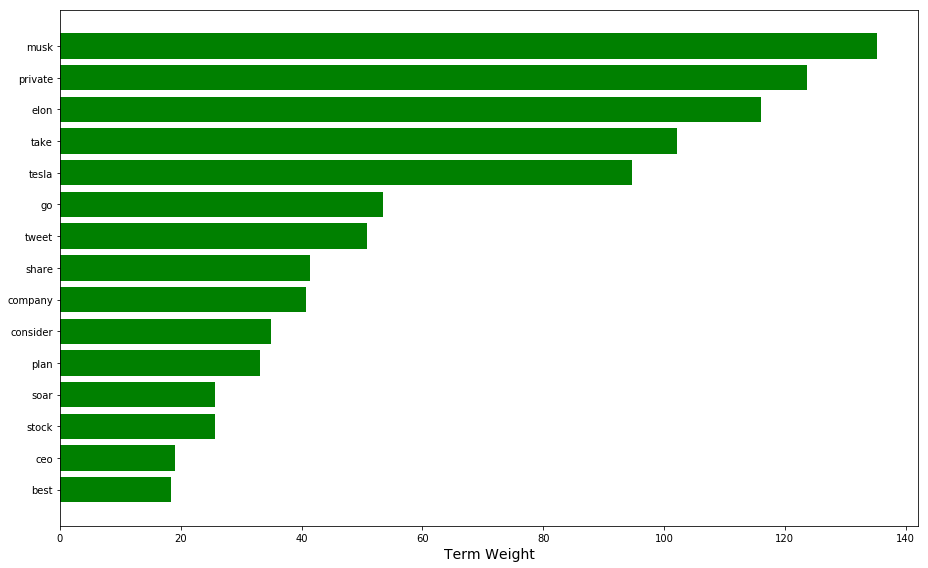


 Topic:  1
01. break tesla stock soar trade halt ceo elon musk tweet consider take electric vehicle company pr 
02. break tesla stock soar trade halt ceo elon musk tweet consider take electric 
03. break tesla share halt ceo elon musk send string tweet consider take company priv 
04. news update elon musk consider take tesla private tsla stock trade halt 
05. tesla share soar elon musk float plan take company private tesla elonmusk 
06. break foxnews ale tesla share soar ceo elon musk float idea take company private 
07. break tesla stock jump musk tweet consider take company private cnbc contact tesla verify mu 
08. tesla stock soar elonmusk tweet plan take company private read financenew 
09. onmanoramalive elon musk take tesla private best path share jump elonmusk tesla privatisation 
10. elon musk take tesla private best path share jump elonmusk tesla privatisation 
11. tech tesla halt trade elon musk tweet want take company private 
12. tesla halt trade elon musk tweet want take 

In [15]:
# Analysis using textblob
from textblob import TextBlob
import collections

#plt.style.use("ggplot")
#matplotlib.rcParams.update({"font.size": 14})

def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

def get_top_tweets( all_tweets, W, topic_index, top ):
    '''
    Returns the most relevant tweets ordered according to their topic relevance
    '''
    
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    
    # now get the snippets corresponding to the top-ranked indices
    top_tweets = []
    top_scores = []
    for doc_index in top_indices[0:top]:
        top_tweets.append( all_tweets[doc_index] )
        top_scores.append(W[doc_index,topic_index])
        #print(W[doc_index,topic_index])
    return top_tweets,top_scores
    
    
# Let us examine the specific weights of the topic    
topic = 0
    
plot_top_term_weights( terms, H, topic, 15 )    


# Let us look now at the most relevant posts for each topic
topic_tweets,top_scores = get_top_tweets( snippets, W, topic, 25 )

print('================================================')
print('\n Topic: ', topic+1)
for i, tweet in enumerate(topic_tweets):
    print("%02d. %s " % ( (i+1), tweet) )
print('================================================\n')

In [16]:
# Now that we have found the specific topics that we want to filter out, we must make a new data frame that removes
# the most relevant tweets in all of these categories.

# Enumerates the topics that we want to remove
drop_topics = [0]
drop_threshold = 0.2 # Tweets that are above the threshold are dropped from the dataframe
drop_tweets = []

for drop_topic in drop_topics:
    topic_tweets,topic_scores = get_top_tweets( snippets, W, drop_topic, len(df))

    
    for i in range(len(topic_tweets)):
        
        # Find the tweets that are above the threshold
        if(topic_scores[i]>=drop_threshold):
            drop_tweets.append(topic_tweets[i])

# This command drops the rows that are in the selected topics
df_cleaned = df[~df['tweet_text'].isin(drop_tweets)]
df_cleaned=df_cleaned.reset_index(drop=True)
N_dropped_topics = len(df_cleaned)


print('=============================================================')
print("Number of processed tweets: ", N_processed_tweets)
print("Number of tweets after topic removal: ", N_dropped_topics)
print("Number of tweets removed: ",  N_processed_tweets-N_dropped_topics)
print('=============================================================')

Number of processed tweets:  1417
Number of tweets after topic removal:  793
Number of tweets removed:  624


In [14]:
# Now we can do an analysis on the final data
print(df_cleaned['tweet_text'].head)

<bound method NDFrame.head of 0                                           free bitcoin
1      amixem hi i like video autopilot technology ca...
2      tesla work new key fob potentially keyless mod...
3      nikola tesla july january bear serbia genius l...
4      digital disruptors software innovation transfo...
5                                                 buyout
6            inside tesla trouble new york solar factory
7      hc recent move tesla amp catl add increasingly...
8      alsuwayed saudi sovereign wealth fund build un...
9                consider take tesla private fund secure
10     tesla buyout large history wide margin etf tra...
11     i dont think ill able keep hold tesla go priva...
12     like get know shell howard jones dance vauxhal...
13     no not tea mission accelerate advent sustainab...
14     kerensky stake price determine market determin...
15                       drive tesla model auto focus ep
16                                   sather edison tesla
1